In [1]:
import numpy as np
import matplotlib.pyplot as plt
from safety_formation.formation import Agent,Topology
import networkx as nx

<Axes: title={'center': 'Topology (Leader=0, Followers=1..N)'}>

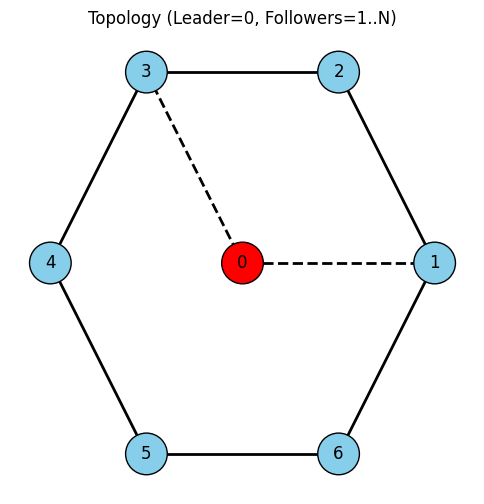

In [6]:
A = np.array([
    [0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0],
], dtype=float)

leader_access = [1, 0, 1, 0, 0, 0]

topology = Topology(6, A, leader_access)

topology.plot()